# Iterate maps modeled in Pytorch Apple M1 (Metal) GPU


In [1]:
import math
import time
from types import SimpleNamespace
from tqdm import tqdm
import wandb

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import utils.iterated_map_utils as map_utils
import utils.ode_utils as ode_utils
import utils.torch_utils as torch_utils

from lorentz.train import RecurrenceModel, create_dataset
from lorentz.test import test

## Lorentz attractor

In 1963, Edward Lorenz developed a simple mathematical model of the way air moves around in the atmosphere.
His model was a system of three ordinary differential equations that demonstrates deterministic chaos at certain parameter values and initial conditions. The Lorenz attractor is the system's strange attractor that resembles a butterfly when visualized.

The Lorenz system is nonlinear, three-dimensional, and deterministic. 

The Lorenz attractor is a set of chaotic solutions of the Lorenz system and is possibly the most famous depiction of a system that exibits chaotic behavior. Very slight changes to the initial conditions of the system lead to wildly different solutions. The system itself describes the movement of a point in a three-dimensional space over time using three ordinary differential equations that represent the movement of this point (x, y, z). In these equations, t represents time and sigma, rho, and beta are constant system parameters.

$$ \frac{dx}{dt} = \sigma (y - x) $$

$$ \frac{dy}{dt} = x (\rho - z) - y $$

$$ \frac{dz}{dt} = x y - \beta z $$

For his famous depiction of chaos, Lorenz used the values sigma = 10, beta = 8/3 and rho = 28. With these parameter values, the system exhibits deterministic chaos. It has a strange attractor with a fractal structure.

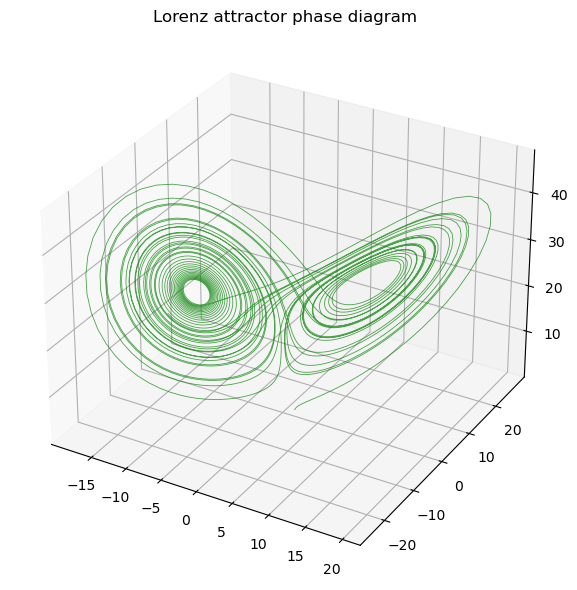

In [2]:
# parameters P and variable vector V
P = {'sigma': 10, 'beta': 8/3, 'rho': 28, 'dt': 0.01, 'n': 4000}
V = [1.5, 0.6, 0.7]
# trajectory T
T = ode_utils.iterate(ode_utils.lorentz_ode, V, **P)
# extract the individual arrays of x, y, and z values from the array of arrays
x, y, z = tuple(T.T)

# plot the lorenz attractor in three-dimensional phase space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.6)
ax.set_title('Lorenz attractor phase diagram')
# fig.savefig('{}/lorenz-attractor-3d.png'.format(save_folder), dpi=180, bbox_inches='tight')
plt.tight_layout()
# plt.show()

## Train model



In [3]:
def train(config: dict=None, config_path: str='./default_config.yaml', log_step=100):

    if not config:
        with open(config_path, encoding='utf-8') as file:
            config = yaml.safe_load(file)

    

    # start a run with config
    run=wandb.init(project=config['project'])
    # set config as default, will be overrulled  by sweep config
    run.config.setdefaults(config)
    # get final config, possibly altered by sweep
    config = SimpleNamespace(**run.config)
    
    # reset seed for reproducibility
    torch_utils.reset_seed(config.seed)

    # create random distributed train and dev dataset
    train_dataset = create_dataset(config.dataset_size, config.device, **config.dataset_parameters)
    dev_dataset = create_dataset(1000, config.device, **config.dataset_parameters)
    X_dev, Y_dev = dev_dataset.get_data()
    # create dataloader for train dataset
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    
    # init model
    model = RecurrenceModel(config.hidden_units_list, config.activation_function)
    model.to(config.device)

    # Define loss and optimizer
    loss_fn = torch.nn.MSELoss(reduction='mean')
    if hasattr(config, 'weight_decay'):
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate)

    num_train_examples = 0
    train_loss=[]
    dev_loss=[]
    test_loss=[]
    for epoch in range(config.epochs):
        with tqdm(train_loader, unit=" batch") as tepoch:
            for step, (X, Y) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}/{config.epochs}")
                
                X, Y = X.to(device=config.device), Y.to(device=config.device)
                optimizer.zero_grad()
                Y_hat = model(X)
                loss = torch.sqrt(loss_fn(Y_hat, Y))
                loss.backward()
                optimizer.step()

                num_train_examples += len(Y)
                tepoch.set_postfix(loss=loss.item(), examples=f'{round(num_train_examples/1000, 0)}K')

                # train_loss.append(loss.item())

                if step % log_step == 0 or step >= len(tepoch)-1: 
                    # calculate dev-set loss
                    Y_dev_hat = model(X_dev)
                    dev_loss_val = torch.sqrt(loss_fn(Y_dev_hat, Y_dev)).item()
                    test_loss_val = test(model, config.map_parameters, config.device)
                    wandb.log({'train_loss': loss.item(), 'dev_loss': dev_loss_val, 'test_loss': test_loss_val})

                    train_loss.append(loss.item())
                    dev_loss.append(dev_loss_val)
                    test_loss.append(test_loss_val)

                                
    # test_loss = test(model, config.map_parameters, config.device)
    # wandb.log({'test_loss': test_loss, 'total_train_examples': num_train_examples})
    wandb.log({'total_train_examples': num_train_examples})

    torch.save(model.state_dict(), os.path.join(wandb.run.dir, "model.pt"))
    #finish run
    run.finish()

    # steps_per_epoch = math.ceil(len(train_loader.dataset) / config.batch_size)
    # epoch_time = [x/steps_per_epoch for x in range(len(train_loss))]

    # return model, epoch_time, train_loss, dev_loss, test_loss
    return model, train_loss, dev_loss, test_loss


## Config

In [4]:
config = SimpleNamespace(
    
    project='iterate-lorentz-best-models',
    
    # reproducability
    seed=33,
    
    # model
    model_name='RecurrenceModel',
    hidden_units_list = [3,20,3],
    activation_function = 'leaky_relu',
    
    # train regime
    batch_size=64,
    epochs=4,

    # learning regime
    optimizer='Adam',
    learning_rate=0.03629093581436244,
    weight_decay=0.006251,
    loss_function='RMSE',

    # train dataset
    dataset_distribution='np.random.normal',
    dataset_parameters={ 'x': { 'mu': 0, 'sigma': 30}, 'y': { 'mu': 0, 'sigma': 30}, 'z': { 'mu': 25, 'sigma': 25}},
    dataset_size=26000,

    # mapping
    map_name='lorentz_ode',
    map_parameters={'sigma': 10, 'beta': 2.6666667, 'rho': 28, 'dt': 0.01},  # 8/3=2.6666667

    # device 
    device='mps',
    dtype='float32',
    gpu_name='M1Pro GPU 16 Cores',

)

dry_run = True
if dry_run:
    os.environ['WANDB_MODE'] = 'dryrun'

run = wandb.init(project=config.project, config=config)

device  = torch_utils.get_device()
model, train_loss, dev_loss, test_loss = train(config.__dict__, device, log_step=10)

run.finish()

pytorch using device: mps


Epoch 4/4: 100%|██████████| 407/407 [00:08<00:00, 47.96 batch/s, examples=104.0K, loss=2.32]


dev_loss,█▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▂▁▂▁▂▁▁▁▁▁▂▂▂▁▁▁▁▂▂▁▂▁▁▁
test_loss,█▄▄▄▁▄▄▂▂▃▂▃▃▅▂▂▄▅▆▄▃▃▃▄▂▂▃▄▅▃▄▂▂▂▅▃▆▃▃▂
total_train_examples,▁
train_loss,█▂▁▂▂▂▂▁▁▂▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▂▂▂▁▂▂▂▂▁▂▃▁▁▁
dev_loss,2.72818
test_loss,0.83359
total_train_examples,104000
train_loss,2.32482


## Visualize loss

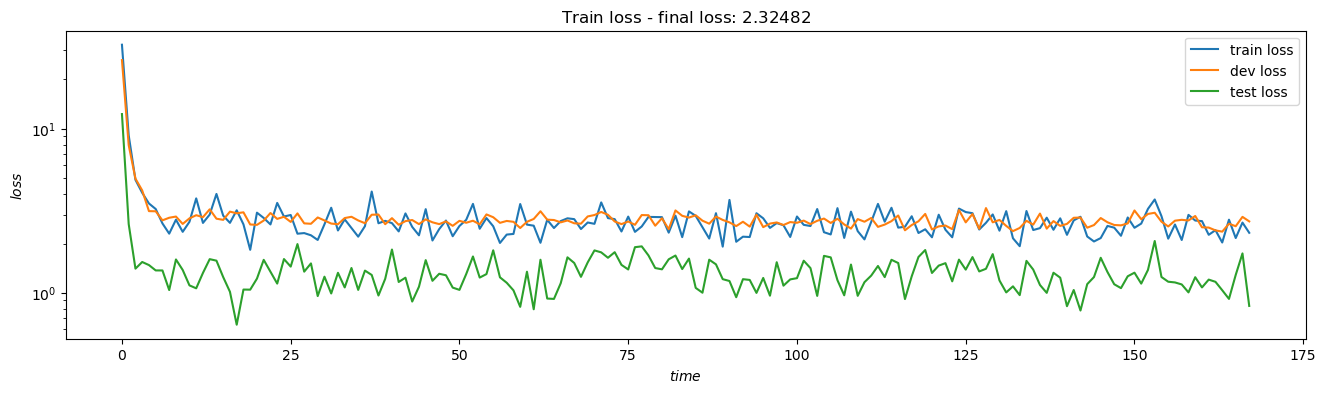

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(train_loss, label='train loss')
ax.plot(dev_loss, label='dev loss')
ax.plot(test_loss, label='test loss')
# ax.plot(epoch_time, train_accuracy, label='accuracy')
ax.set_title(f'Train loss - final loss: ${train_loss[-1]: .5f}$')
ax.set_xlabel('$time$')
ax.set_ylabel('$loss$')
ax.set_yscale('log')
ax.legend(loc="upper right")
plt.show()

## Visualize actual vs predicted

In [16]:
P = config.map_parameters
x0 = [1.5, 0.6, 0.7]

X = ode_utils.iterate(ode_utils.lorentz_ode, x0, n=3501, **P)
Y_dot = X[1:,:]
X = X[:-1,:]

X_torch = torch.tensor(X, dtype=torch.float32).to(device)
Y_hat = model(X_torch)
Y_hat = Y_hat.cpu().detach().numpy()

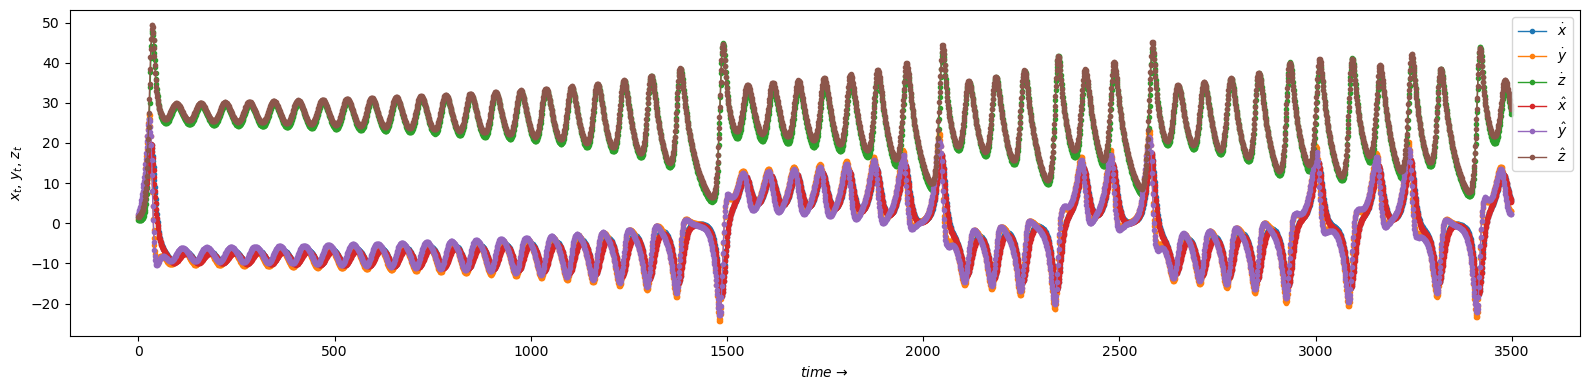

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))  #, gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

ax1.plot(Y_dot, marker='.', lw=1, label=['$\dot{x}$', '$\dot{y}$', '$\dot{z}$'])
ax1.plot(Y_hat, marker='.', lw=1, label=['$\hat{x}$', '$\hat{y}$', '$\hat{z}$'])

ax1.set_xlabel(f'$time$ $→$')
ax1.set_ylabel(f'$x_t$, $y_t$, $z_t$')
# ax1.legend(loc="upper left")
ax1.legend()

plt.tight_layout()

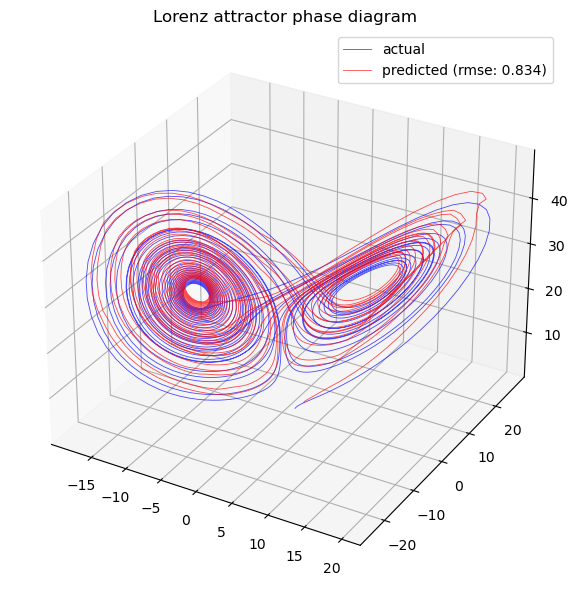

In [18]:
x_dot, y_dot, z_dot = tuple(Y_dot.T)
x_hat, y_hat, z_hat = tuple(Y_hat.T)

rmse_loss = np.sqrt(np.mean((Y_hat-Y_dot)**2))

# plot the lorenz attractor in three-dimensional phase space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot(x_dot, y_dot, z_dot, color='b', alpha=0.7, linewidth=0.6, label='actual')
ax.plot(x_hat, y_hat, z_hat, color='r', alpha=0.7, linewidth=0.6, label=f'predicted (rmse: {rmse_loss:.3f})')
ax.set_title('Lorenz attractor phase diagram')
ax.legend()

# fig.savefig('{}/lorenz-attractor-3d.png'.format(save_folder), dpi=180, bbox_inches='tight')
plt.tight_layout()